In this experiment, the site was conducting an A/B test with the goal of increasing revenue. The dataset provided contains data about the users (USER_ID), the test group (VARIANT_NAME) and the revenue they generated (REVENUE).

In [ ]:
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

path = kagglehub.dataset_download("sergylog/ab-test-data")

df = pd.read_csv(f"{path}/AB_Test_Results.csv")

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [41]:
print(" INFO ".center(50, "-"))
print(df.info())
print(" DESCRIBE ".center(50, "-"))
print(df.describe())
print(" DUPLICATES ".center(50, "-"))
print(df.duplicated().sum())
print(" SHAPE".center(50, "-"))
print(f"Rows: {df.shape[0]}", f"Columns: {df.shape[1]}", sep="\n")
print(" SIZE EACH GROUPS ".center(50, "-"))
df.groupby('VARIANT_NAME').size()

---------------------- INFO ----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None
-------------------- DESCRIBE --------------------
            USER_ID       REVENUE
count  10000.000000  10000.000000
mean    4981.080200      0.099447
std     2890.590115      2.318529
min        2.000000      0.000000
25%     2468.750000      0.000000
50%     4962.000000      0.000000
75%     7511.500000      0.000000
max    10000.000000    196.010000
------------------- DUPLICATES -------------------
2067
---------------------- SHAPE----------------------
Rows: 10000
Columns: 3
---------------- SIZE EACH GROUPS ----------------


VARIANT_NAME
control    4984
variant    5016
dtype: int64

In [ ]:
# Number of unique users in each group  
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()


VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

You can see that many users are in groups A and B. In order not to affect the statistics, we will remove them and leave only unique users. (Which belong to only one of the groups) 

In [43]:
one_variant = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
one_variant = one_variant[one_variant]

df = df[df['USER_ID'].isin(one_variant.index)]

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

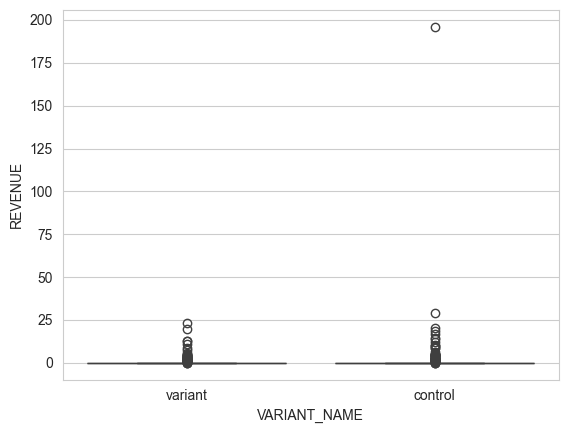

In [44]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In the control group, we see an outlier. It needs to be removed

In [45]:
print(df.sort_values(by='REVENUE', ascending=False).head(5))
df = df.drop(index=1437)

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
2482     7356      variant    23.04
6412     1053      control    20.07
5217     3684      variant    19.47


Since the records represent users' visits rather than their total revenue, we should group the data by users and sum up their revenue.

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

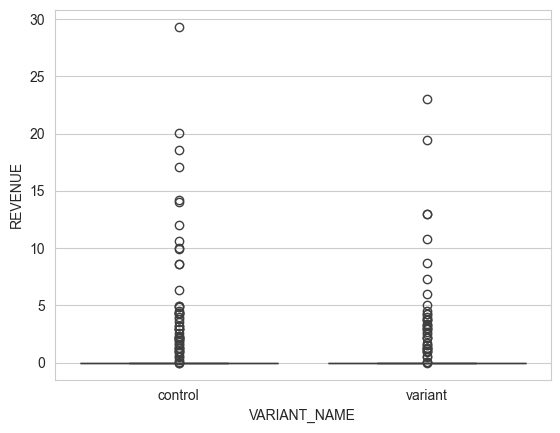

In [46]:
df = df.groupby(['USER_ID', 'VARIANT_NAME']).sum().reset_index()
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In [47]:
df.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'std', 'sum'])

,mean,std,sum
VARIANT_NAME,,,
control,0.114923,1.162495,274.55
variant,0.074935,0.858207,179.32


Statistical analysis

Before applying the t-test, it is necessary to check the samples for normality of distribution.

In [48]:
print(f'Variant: {shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])}')
print(f'Control: {shapiro(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])}')

Variant: ShapiroResult(statistic=np.float64(0.06145986897942335), pvalue=np.float64(9.962810723092505e-76))
Control: ShapiroResult(statistic=np.float64(0.07461183698139795), pvalue=np.float64(2.1235957244761016e-75))


Since both our samples do not have a normal distribution (p_value < 0.05), it follows that the t-test cannot be applied. Let's use the Mann-Whitney test

MannwhitneyuResult(statistic=np.float64(2845109.0), pvalue=np.float64(0.24799555106821947))

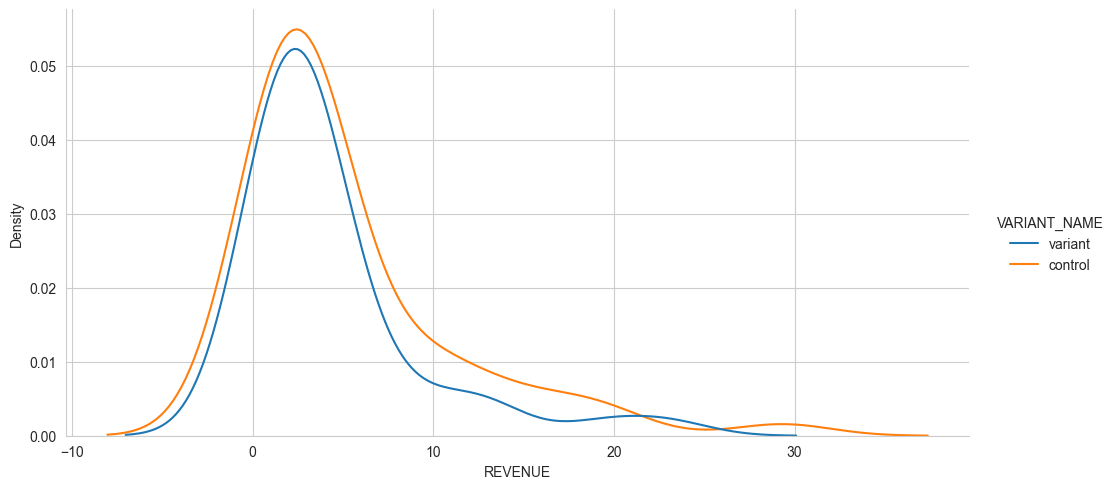

In [49]:
temp_df = df[df['REVENUE'] > 0]

sns.set_style('whitegrid')
sns.displot(data=temp_df, x='REVENUE', hue='VARIANT_NAME', kind='kde', height=5, aspect=2)


mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

Since p-value > 0.05, we fail to reject the null hypothesis, indicating that there is no statistically significant difference between the groups.

Bootstrap

The Mann-Whitney p-value test showed no statistically significant difference between the groups. For additional analysis, we used bootstrap to plot the confidence interval (CI) of the difference in mean values. This will allow us to assess the differences between the groups and the reliability of the results.

CI: (np.float64(-0.09922138988647125), np.float64(0.01684085121999299))


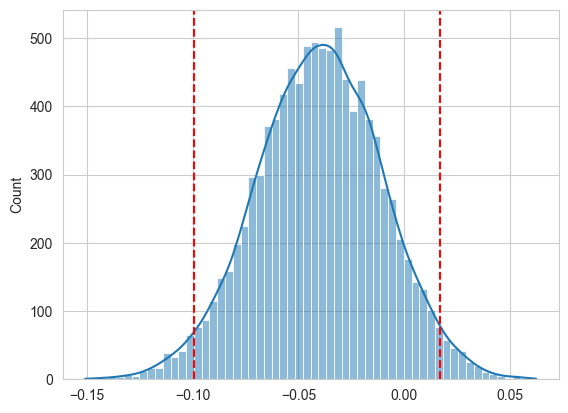

In [50]:
def bootstrap(control_group, test_group, n=10000, ci=95):
    boot_means = []
    for _ in range(n):
        sample1 = np.random.choice(control_group, size=(len(control_group)), replace=True)
        sample2 = np.random.choice(test_group, size=(len(test_group)), replace=True)
        boot_means.append(sample2.mean() - sample1.mean())

    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)

    return lower, upper, boot_means
    

ci_lower, ci_upper, boot_means = bootstrap(df[df['VARIANT_NAME'] == 'control']['REVENUE'], df[df['VARIANT_NAME'] == 'variant']['REVENUE'])
                                 

print(f'CI: {ci_lower, ci_upper}')

sns.histplot(boot_means, kde=True)
plt.axvline(ci_lower, color='red', linestyle='--')
plt.axvline(ci_upper, color='red', linestyle='--')

**Conclusion**

1. Mann-Whitney test showed that **p-value > 0.05**, which means that there was no statistically significant difference between the groups
2. Bootstrap confidence interval **(CI): (-0.0988, 0.0162)**. This means that the possible values of the income difference between the groups include 0, which means that we cannot claim that the new variant performs better.

**Implementation of the change tested is not recommended as it did not show a statistically significant impact on revenue.**

